In [1]:
import numpy as np 
import math
import random
from matplotlib import pyplot as plt 

In [38]:
#方法1  得到zipf分布的文件请求概率
def zipf_distrubute(alpha,file_number):
    ans=[0 for i in range(file_number)]
    sum=0
    for i in range(1,file_number+1):
        sum+=1/pow(i,alpha)
    for i in range(1,file_number+1):
        ans[i-1]=(1/pow(i,alpha))/sum
    return ans

#方法2  在圆环形内生成随机terminal的坐标
def random_point(car_num,radius):
    x_index=[]
    y_index=[]
    for i in range(1, car_num + 1):
        theta = random.random() * 2 * np.pi
        r = random.uniform(0, radius)
        x = math.cos(theta) * (r ** 0.5)
        y = math.sin(theta) * (r ** 0.5)
        x_index.append(x)
        y_index.append(y)
    
    return  x_index,y_index

#方法3  得到可以相互通信的用户集合
def candi_terminal(x_label,y_label,r_max):
    x=len(x_label)
    y=len(y_label)
    terminal_can_com= [[0 for i in range(x)] for j in range(y)]
    for i in range(0,x):
        for j in range(0,y):
            d=pow((x_label[i]-x_label[j]),2)+pow((y_label[i]-y_label[j]),2)
            if d<=pow(r_max,2):
                terminal_can_com[i][j]=1
    return terminal_can_com


#方法4   得到基站内所有用户平均的请求命中概率
def hit_rate(user_number,file_number,is_cache_file,candidate_user,user_request_file_rate):
    ans = 0
    for user in range(user_number):
        for file in range(file_number):
            for candi in range(user_number):
                if is_cache_file[candi][file]==1&candidate_user[user][candi]==1:
                    ans+=user_request_file_rate
                    break
    return ans/user_number

    # for i in range(user_number):
    #     for file in range(len(is_cache_file[i])):
    #         if  is_cache_file[i][file]==1:
    #             for user__ in range(len(candidate_user[i])):
    #                 if candidate_user[i][user__]==1 & is_cache_file[i][file]==1:
    #                     ans+= user_request_file_rate*is_cache_file[i][file]*candidate_user[i][user__]
    #                     break
                    
#方法5    
def cache_which_file(user_number,cache_size,file_number):
    is_cache_file=[[0 for i in range(user_number)] for j in range(file_number)]
    
    for j in range(user_number):
        for i in range(file_number):
            if sum(is_cache_file[j])>=cache_size+j:
                break
            if user_number != 1:
                is_cache_file[j][i]=1

    print(is_cache_file)
    return is_cache_file


#方法6    0-1背包问题得到最大效能
def dp_01(file_size,cache_size,file_utility) -> list:
    dp=[[0 for i in range(len(file_size)+1)] for j in range(cache_size+1)]
    for i in range(1,len(file_size)+1):
        for j in range(1,cache_size+1):
            if j-file_size[i]<=0:
                dp[i][j]=dp[i-1][j]
            else:
                dp[i][j]=max(dp[i-1][j],file_utility[i-1]+dp[i-1][j-file_size[i-1]])
    return dp

#方法7     从上述最大效能 倒推 存的哪些文件。 与方法6连用。
def cache_which_file_01(dp,file_size,cache_size):
    cache_index=[]
    k=len(file_size)
    l=cache_size
    for i in range(100):
        if dp[k][l]==dp[k-1][l]:
            k=k-1
        else:
            cache_index.append(k-1)
            l -= file_size[k-1]
            k=k-1

        if k==0:
            break

    return cache_index

def n_is_or_not_hit_m(cache_set,n,m,n_communcation_set_n_):
    
    if cache_set[n][m]==1:
        return 1

    for i in range(len(n_communcation_set_n_)):
        if cache_set[n_communcation_set_n_[i]][m]==1:
            return 1
    
    return 0

#公式（1）的实现 用户n的自命中概率
def n_hit_possible_self(cache_set,n,m_request_set):
    P=0
    for i in range(len(m_request_set[n])):
        P+= cache_set[n][i]*m_request_set[n][i]

    return P

#公式(2)的实现  用户n的d2d命中概率
def n_hit_possible_D2D(cache_set,n,m_request_set,n_communcation_set_n_):
    P=0
    for i in range(len(m_request_set[n])):
        if cache_set[n][i]==1:
            continue
        for j in range(len(n_communcation_set_n_)):
            if n_communcation_set_n_==n:
                continue
            if cache_set[n_communcation_set_n_[j]][i]==1:
                P+= m_request_set[n][i]
                break

    return P

#公式(3)的实现
def n_hit_possbile_no_BS(cache_set,n,m_request_set,n_communcation_set_n_):

    return n_hit_possible_self(cache_set,n,m_request_set)+n_hit_possible_D2D(cache_set,n,m_request_set,n_communcation_set_n_)

#系统的平均命中概率，这个是我们要得到的最大值
def all_hit_possible(cache_set,n_communcation_set_n_,m_request_set):
    P=0
    for i in range(len(cache_set)):
        P+=n_hit_possbile_no_BS(cache_set,i,m_request_set,n_communcation_set_n_[i])

    return P/(len(cache_set))

# 生成 n_cache清空后 所有文件的被他缓存的价值矩阵
def clear_n_cache_set_all_file_value(cache_set,n,n_communcation_set_n_,m_request_set):
    cache_set[n]=[0 for i in range(len(m_request_set[n]))]
    file_value=[0 for i in range(len(m_request_set[n]))]

    for h in range(len(file_value)):
        file_value[h]+=m_request_set[n][h]
        for j in range(len(n_communcation_set_n_)):
            n_=n_communcation_set_n_[j]
            if n_is_or_not_hit_m(cache_set,n_,h,n_communcation_set_n_)==0:
                file_value[h]+=m_request_set[n_][h]
    
    return file_value

def reset_n_local_cache(file_value,file_size,cache_size,cache_set):
    dp=[[0 for i in range(cache_size+1)] for j in range(len(file_size)+1)]
    for i in range(1,len(file_size)+1):
        for j in range(1,cache_size+1):
            if j-file_size[i-1]<=0:
                dp[i][j]=dp[i-1][j]
            else:
                dp[i][j]=max(dp[i-1][j],file_value[i-1]+dp[i-1][j-file_size[i-1]])
    
    xxx=cache_which_file_01(dp,file_size,cache_size)
    
    for i in range(len(xxx)):
        cache_set[xxx[i]]=1

def random_requert_zipf(file_Numbers,terminal_number):
    file_required_by_terminal=[[0 for i in range(file_Numbers)]for j in range(terminal_number)]
    for j in range(len(file_required_by_terminal)):
        file_required_by_terminal[j]=zipf_distrubute(1.05,file_Numbers)
        random.shuffle(file_required_by_terminal[j])
    return file_required_by_terminal

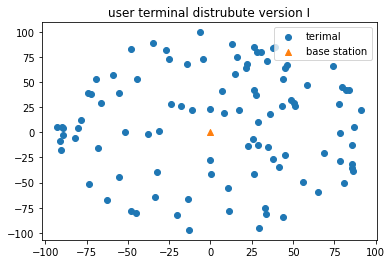

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0.233688747484687
0.233688747484687
0.233688747484687
0.233688747484687
0.233688747484687
0.233688747484687
0.233688747484687
0.233688747484687
0.233688747484687
0.233688747484687
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,

In [39]:
class BaseStation(object):

    def __init__(self,user_number,file_number,R_max,r_max,cache_size) -> None:
        #const
        self.user_number=user_number
        self.file_number=file_number
        self.R_max=R_max**2
        self.x_set,self.y_set=random_point(self.user_number,self.R_max)
        self.request_possible_2_user_file_set=random_requert_zipf(self.file_number,self.user_number)
        self.size_file_set=[random.randint(1,5) for i in range(self.file_number)]
        self.communicate_2_user_user=candi_terminal(self.x_set,self.y_set,r_max)
        self.cache_size=cache_size
        #var
        self.cache_2_user_file_set=[[0 for i in range(self.file_number)]for j in range(self.user_number)]
    
   
    def run(self,time):
        for k in range(time):
            for n in range(self.user_number):
                value=clear_n_cache_set_all_file_value(self.cache_2_user_file_set,n,self.communicate_2_user_user[n],self.request_possible_2_user_file_set)
                reset_n_local_cache(value,self.size_file_set,self.cache_size,self.cache_2_user_file_set[n])
            print(all_hit_possible(self.cache_2_user_file_set,self.communicate_2_user_user,self.request_possible_2_user_file_set))

        return 
           
    def plt(self):        
        plt.title("user terminal distrubute version I") 
        plt.scatter(self.x_set, self.y_set, marker='o', label="terimal")
        plt.scatter(0, 0, marker='^', label="base station")
        plt.legend(loc='best')
        plt.show()







BS=BaseStation(100,50,100,30,10)
BS.plt()
print(BS.cache_2_user_file_set[0])

BS.run(10)
print(BS.cache_2_user_file_set)

# print(BS.cache_2_user_file_set[0])
# print(BS.request_possible_2_user_file_set[0])
# print(BS.size_file_set)


In [41]:
print(BS.request_possible_2_user_file_set[0])

[0.013135276139481816, 0.010391630444700572, 0.005952677114649683, 0.03678801680179467, 0.00703472769728367, 0.01405624657823734, 0.006558966466727549, 0.008581108342321205, 0.005018826681648864, 0.005605928615487751, 0.016335208012220576, 0.07617068682517056, 0.0042370387730036345, 0.005154034860655169, 0.006142222607869291, 0.005296541904390134, 0.006788719609122499, 0.03129048156495276, 0.009872677022037589, 0.01232519563950023, 0.01946717216114338, 0.010966648102542234, 0.004055639134039122, 0.005446949875690731, 0.004434983920621159, 0.027196981304352212, 0.008221066854821966, 0.004540878469568416, 0.056312161557531125, 0.1165960112924016, 0.01511230644657051, 0.006343920206792591, 0.0075828634725436505, 0.008973274662419027, 0.0047681886996638325, 0.021516181001841352, 0.004144402145144056, 0.0048903747395713055, 0.004333805992925684, 0.01160724252234625, 0.24141552150167309, 0.0072987629052937986, 0.02403314209181038, 0.004651824382474394, 0.007889385429774033, 0.017767440948975